## Generate synchronization data

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Set up parameters and fix an initial condition
max_iter = 500
t = np.arange(max_iter)
N = 30
dt = 0.01
phi0 = 2 * np.pi * np.random.rand(N)

W = 5 * np.random.rand(N) # Natural freqs
K = 5 # Coupling
A = np.zeros((N,N))
L = np.zeros((N,N))
deg = np.sum(A,axis=0)
eigSort = sorted(np.linalg.eig(L)[0])
while np.abs( eigSort[1] ) < 1e-5:
    ni = np.random.randint(N)
    nj = np.random.randint(N)
    if (ni != nj) and (A[ni,nj] == 0):
        A[ni,nj] = 1
        A[nj,ni] = 1
        deg[ni] += 1
        deg[nj] += 1
        L = np.diag(deg) - A
        eigSort = sorted(np.linalg.eig(L)[0])
M = int(sum(deg)/2)
D = np.zeros((N,M))
Dind = 0
for i in range(N):
    for j in range(i):
        if A[i,j] > 0:
            D[i,Dind] = 1
            D[j,Dind] = -1
            Dind += 1

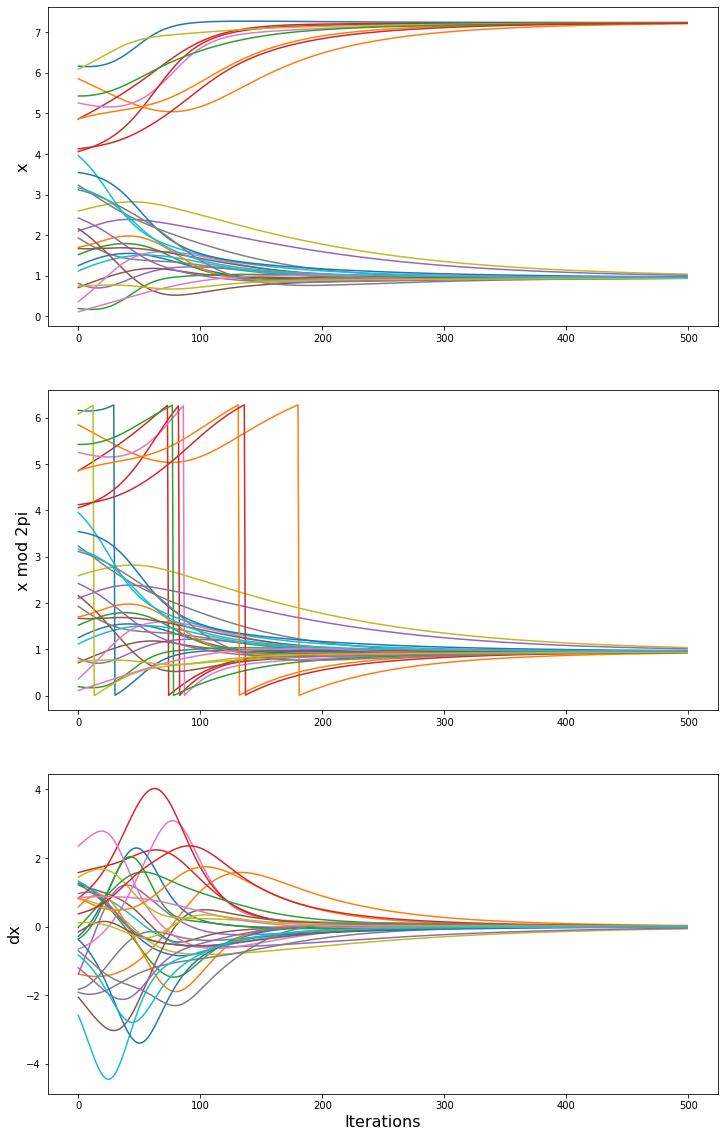

In [11]:
# Run simulation to obtain data. This one takes no input.
x = np.zeros((N,max_iter))
dx = np.zeros((N,max_iter))
u = np.zeros((N, max_iter)) # history of inputs
DTxu = np.zeros((M, max_iter)) # History of D^Tx - u, or should it be D^T(x - u)
fxu = np.zeros((M, max_iter)) # History of f(thea bove)
x[:,0] = phi0
# x[:,0] = phi0 / 10 - np.pi*0.1
# x[15:,0] = phi0[15:]/10 + np.pi*0.9
# x[:10,0] = phi0[:10]/10 - np.pi

# Define input u
u0 = np.zeros((N,))#W#.squeeze()

for k in range(max_iter):
    u[:,k] = u0
    # ux = np.zeros((N,1))
    # for i in range(N):
    #     for j,Aij in enumerate(A[i,:]):
    #         if Aij > 0:
    #             ux[i,0] = ux[i,0] + np.sin( x[j,k]-x[i,k] )
    # ux = (W + K * ux).squeeze()
    DTxu[:,k] = np.matmul(D.T, x[:,k] - u[:,k])
    fxu[:,k] = np.sin(DTxu[:,k])
    ux = -np.matmul(D, fxu[:,k])
    dx[:,k] = ux[:]
    if k < max_iter-1:
        x[:,k+1] = x[:,k] + ux * dt
    
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12,20))
ax1.plot( t , x.T )
ax2.plot( t , (x % (np.pi*2)).T )
ax3.plot( t , dx.T )
ax3.set_xlabel('Iterations',fontsize=16)
ax1.set_ylabel('x',fontsize=16)
ax2.set_ylabel('x mod 2pi',fontsize=16)
ax3.set_ylabel('dx',fontsize=16)
plt.show()

### See if we can let a network learn the D matrix

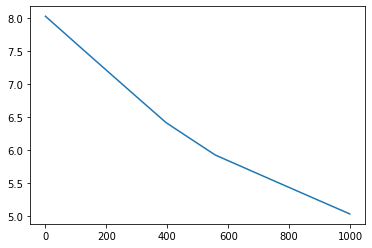

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim

# Build a simple network.
# Input: f(D^Tx), which is of shape (M,1)
# Output: \dot{x}, which is of shape (N,1)
hidden = 32
D_net = nn.Sequential(
    nn.Linear(M, hidden),
    nn.ReLU(),
    nn.Linear(hidden, N),
    nn.ReLU()
)
loss_hist = []
# Regularize it to enforce sparsity: https://discuss.pytorch.org/t/l1-regularization-for-a-single-matrix/28088/2
criterion = nn.functional.mse_loss
optimizer = optim.SGD(D_net.parameters(), lr=1e-3)
input_data = torch.from_numpy(fxu.T.astype('float32'))
output_data = torch.from_numpy(dx.T.astype('float32'))
for e in range(1000):
    optimizer.zero_grad()
    pred = D_net(input_data)
    loss = criterion(pred, output_data)
    
    #l1_norm = torch.norm(D_net[0].weight, p=1)
    #loss += l1_norm
    for W in D_net.parameters():
        loss += W.norm(2)
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.detach().numpy())
plt.plot( loss_hist)

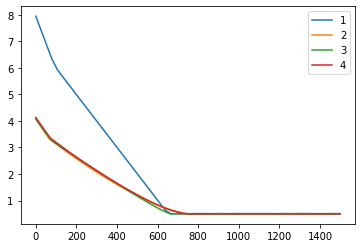

In [35]:
# Try different network structures? 
hidden = 32
D_net = nn.Sequential(
    nn.Linear(M, hidden),
    nn.ReLU(),
    nn.Linear(hidden, N),
    nn.ReLU()
)
D_net2 = nn.Linear(M, N)
D_net3 = nn.Sequential(
    nn.Linear(M, N),
    nn.ReLU()
)
D_net4 = nn.Sequential(
    nn.Linear(M, N),
    nn.Tanh()
)
D_list = [D_net, D_net2, D_net3, D_net4]
loss_hist = [[] for D in D_list]
l1_loss_hist = [[] for D in D_list]

# Regularize it to enforce sparsity: https://discuss.pytorch.org/t/l1-regularization-for-a-single-matrix/28088/2
criterion = nn.functional.mse_loss
optimizer = [optim.SGD(D.parameters(), lr=5e-3) for D in D_list]

input_data = torch.from_numpy(fxu.T.astype('float32'))
output_data = torch.from_numpy(dx.T.astype('float32'))

for e in range(1500):
    for i in range(len(D_list)):
        optimizer[i].zero_grad()
        pred = D_list[i](input_data)
        loss = criterion(pred, output_data)
        l1_loss = loss
        for W in D_list[i].parameters():
            l1_loss += W.norm(2)
        l1_loss.backward()
        optimizer[i].step()
        loss_hist[i].append(loss.detach().numpy())
        l1_loss_hist[i].append(l1_loss.detach().numpy())
# plt.plot( loss_hist)
plt.plot( np.asarray(loss_hist).T)
plt.legend(['1','2','3','4'])

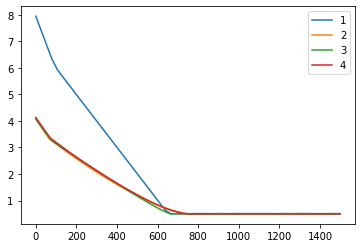

In [36]:
plt.plot( np.asarray(l1_loss_hist).T)
plt.legend(['1','2','3','4'])